# Homework VI - On Fairness

## Task 1

Let's encode this problem with random variables: $Y$ indicating whether an individual will use XAI, $\hat{Y}$ indicating whether an individual has been enrolled in training, $A$ being the protected attribute i.e. group membership. Then:

- $P(\hat{Y} = 1 \mid A = \text{Red}) = 0.5$, whereas $P(\hat{Y} = 1 \mid A = \text{Blue}) = 0.65$, so there is no demographic parity; the *dis*parity is equal to $0.65/0.5 = 1.3$. As a sidenote, it violates the four-fifths rule;
- $P(\hat{Y} = 1 \mid A = \text{Red}, Y = 1) = 0.5$, and $P(\hat{Y} = 1 \mid A = \text{Blue}, Y = 1) = 60 / (60 + 20) = 0.75$, so the equal opportunity coefficient is equal to $1.5$;
- $P(Y = 1 \mid A = \text{Red}, \hat{Y} = 1) = 0.5$, and $P(Y = 1 \mid A = \text{Blue}, \hat{Y} = 1) = 60/65$, wherefore the predictive rate parity coefficient is equal to $\approx 1.846$.

## Task 2

In [1]:
import pandas as pd
import dalex
import dalex.fairness
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Union
import plotly.offline as py
import plotly.io as pio
from scipy.special import logit
from copy import deepcopy
import warnings
warnings.filterwarnings(action="ignore")
pio.renderers.default = "jpeg"

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from lightgbm.sklearn import LGBMClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_sample_weight

import optuna
from optuna.trial import Trial, FrozenTrial
from optuna.integration.sklearn import OptunaSearchCV

import shap
import shap.maskers
import dalex
import lime

### Data

We're going to deal with an [Adult Income dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset). Let's have quick peek at it:

In [2]:
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

There are a few things to node:
1. `income`, the "response variable" in question, is binary (whether the annual income is below or above $50K.)
2. Missing values have been marked with a question sign. Because in many cases these occur in the context of categorical features, we cannot, say, impute the mean value. I've decided to rather replace it with a most frequent value, and moreover keep an additional indicator feature for whether the value was missing.
3. Whereas most features are self-explanatory, one stands out - `fnlwgt`. According to the description presented [here](https://www.kaggle.com/datasets/uciml/adult-census-income), it's correlated with the estimated population total for a given set of demographic characteristics. Although it could very well be useful in deployment, when we may wish to assign various weights to observations in the train set so as for our model to better perform when faced with real-world data and real-world demographics, which may or may not be aligned with train-set-infered demographic statistics, I fail to see how it can be used for the task at hand, as it's "just" a weighing term. I have therefore decided to drop it from the set of features.

In [4]:
num_vars = [
    "age", "educational-num", "capital-gain", "capital-loss",
    "hours-per-week",
]

cat_vars = [
    "workclass", "marital-status", "occupation", "relationship",
    "race", "gender", "native-country",
]

vars_to_drop = [
    "fnlwgt", "education",
]

label_var = "income"

In [5]:
from sklearn.base import TransformerMixin
import numpy as np
import scipy.sparse as sparse

def DfAware(T):
    class DfAwareT(T):
        def transform(self, X):
            if isinstance(X, pd.DataFrame):
                values = super().transform(X)
                return self._to_df(values, X)
            else:
                return super().transform(X)
        
        def fit_transform(self, X, y=None):
            if isinstance(X, pd.DataFrame):
                values = super().fit_transform(X, y)
                return self._to_df(values, X)
            else:
                return super().fit_transform(X, y)
        
        def _to_df(self, values, X):
            if sparse.issparse(values):
                values = values.todense()
            elif not isinstance(values, np.ndarray):
                values = np.asarray(values)
            
            return pd.DataFrame(
                data=values,
                columns=self.get_feature_names_out(),
                index=X.index,
            )
    
    return DfAwareT

DfColumnTransformer = DfAware(ColumnTransformer)
DfSimpleImputer = DfAware(SimpleImputer)

In [6]:
one_tf = Pipeline(steps=[
    ("drop", DfColumnTransformer(
        transformers=[
            ("drop", "drop", vars_to_drop),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )),
    ("fillna", DfSimpleImputer(
        missing_values="?",
        strategy="most_frequent",
        add_indicator=True,
    )),
    ("01", DfColumnTransformer(
        transformers=[
            ("01", OneHotEncoder(drop="if_binary"), [*cat_vars, label_var]),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )),
])

one_df = one_tf.fit_transform(df)
# one_df.head()

In [7]:
def split(df, label_col):
    X, y = df.drop(columns=[label_col]), df[label_col]
    train_X, test_X, train_y, test_y = \
        train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return train_X, test_X, train_y, test_y

train_X, test_X, train_y, test_y = split(df, "income")
train_X_one, test_X_one, train_y_one, test_y_one = split(one_df, "income_>50K")

In [8]:
X_conv_tf = Pipeline(steps=[
    ("drop", DfColumnTransformer(
        transformers=[
            ("drop", "drop", vars_to_drop),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )),
    ("fillna", DfSimpleImputer(
        missing_values="?",
        strategy="most_frequent",
        add_indicator=True,
    )),
    ("01", DfColumnTransformer(
        transformers=[
            ("01", OneHotEncoder(drop="if_binary"), cat_vars),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )),
])

X_conv_tf = X_conv_tf.fit(train_X)

y_conv_tf = LabelEncoder()
y_conv_tf = y_conv_tf.fit(train_y)

In [9]:
class OptunaTrainer:
    def fit(self, X, y):
        def model_fn(trial: Union[Trial, FrozenTrial]):
            return LGBMClassifier(
                max_depth=int(trial.suggest_float("max_depth", 3, 18, step=1)),
                reg_alpha=int(trial.suggest_float("reg_alpha", 40, 180, step=1)),
                reg_lambda=trial.suggest_float("reg_lambda", 0, 1),
                colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1),
                min_child_weight=int(trial.suggest_float("min_child_weight", 0, 10, step=1)),
                n_estimators=180,
                seed=42,
            )

        sample_wt = compute_sample_weight(
            class_weight="balanced",
            y=y,
        )
        
        fit_params = dict(
            sample_weight=sample_wt,
        )

        def objective(trial: optuna.Trial):
            model = model_fn(trial)
            return np.min(cross_val_score(model, X, y, scoring="roc_auc", fit_params=fit_params))
        
        optuna.logging.set_verbosity(optuna.logging.WARN)
        sampler = optuna.samplers.TPESampler(seed=99)
        study = optuna.create_study(direction="maximize", sampler=sampler)
        study.optimize(objective, n_trials=16)

        model = model_fn(study.best_trial)
        model.fit(X, y, **fit_params)
        return model

lgbm_model = OptunaTrainer().fit(train_X_one, train_y_one)

In [10]:
# roc_auc_score(test_y_one, lgbm_model.predict(test_X_one))

In [11]:
lr_model = LogisticRegressionCV(
    solver="liblinear",
    scoring="roc_auc",
    class_weight="balanced",
)

lr_model = lr_model.fit(train_X_one, train_y_one)

In [12]:
# roc_auc_score(test_y_one, lr_model.predict(test_X_one))

### Task 2.2. Fairness coefficients for LightGBM

#### "Sanity check" and deciding on the privileged group membership

Before we compute the fairness coefficients, it's probably a good idea to check what values of the protected attributes might correspond to the privileged class. Although (unfortunately) we may make a pretty good guess without looking at the data, it could prove illuminating regardless. To be more specific, we will look at Partial Dependency Profiles, which (as we've learned in one of previous reports) describes average prediction of the model as we vary one of the features. In this case, we will vary the values of the protected characteristics:

In [13]:
def _predict_fn(model, X_df):
    return model.predict_proba(X_conv_tf.transform(X_df))[:,1]

lgbm_expl = dalex.Explainer(lgbm_model, test_X, y_conv_tf.transform(test_y),
    predict_function=_predict_fn, verbose=False)

- Age:

Calculating ceteris paribus: 100%|██████████| 14/14 [00:01<00:00,  9.12it/s]


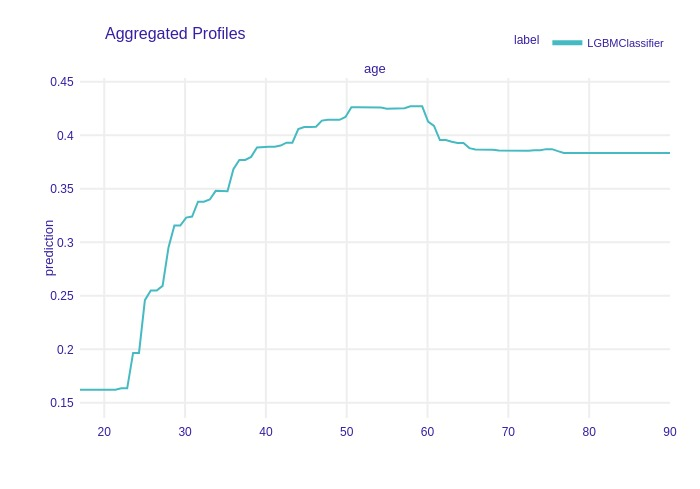

In [14]:
profiles = lgbm_expl.model_profile()
profiles.plot(variables=["age"])

Not surprisingly, predicted income bracket is increasingly "$50K+" as the age of an individual increases, whereafter it drops after around 60, presumably due to retirement. We might therefore regard the age bracket of 40 to 60 as the "privileged class" for age.

- Gender:

Calculating ceteris paribus: 100%|██████████| 14/14 [00:01<00:00,  8.54it/s]


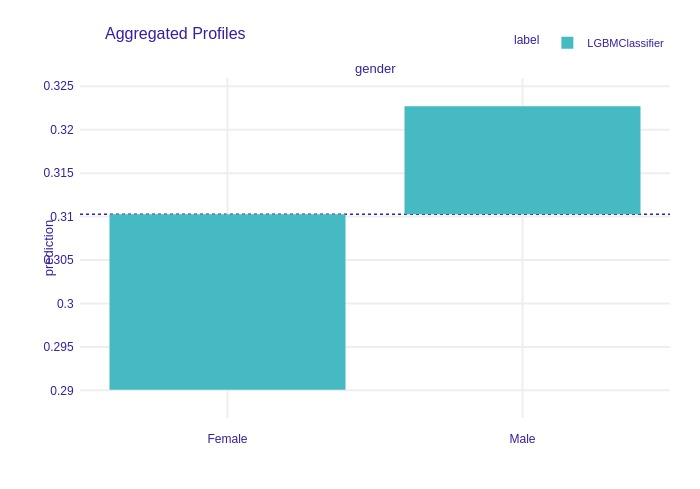

In [15]:
profiles = lgbm_expl.model_profile(variable_type="categorical")
profiles.plot(variables=["gender"])

As we can see, predicted probability of being in the 50k+ income bracket is around 3 percentage points higher for men than for women. Needless to say, men comprise the privileged subgroup, as regards gender.

- Race:

Calculating ceteris paribus: 100%|██████████| 14/14 [00:01<00:00, 10.37it/s]


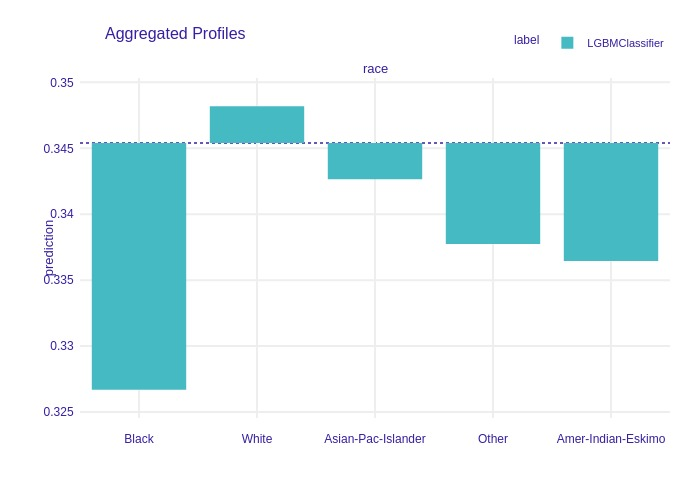

In [16]:
profiles = lgbm_expl.model_profile(variable_type="categorical")
profiles.plot(variables=["race"])

Similarly with gender, our suspicions are confirmed - white people are a privileged class in this instance.

#### Fairness coefficients

With all that, we can move on to the computation of fairness coefficients.

- Age

Let's first check the various metrics for different subgroups:

In [17]:
age_protected = test_X["age"].apply(lambda age: "<40" if age < 40 else ">60" if age > 60 else "40..60")

fairness_ = lgbm_expl.model_fairness(
    protected=age_protected,
    privileged="40..60",
)

fairness_.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
40..60,0.910,0.657,0.607,0.926,0.090,0.343,0.393,0.074,0.750,0.552
<40,0.807,0.888,0.579,0.960,0.193,0.112,0.421,0.040,0.875,0.223
>60,0.773,0.817,0.562,0.922,0.227,0.183,0.438,0.078,0.807,0.320


Let's quickly recap the statistical metrics and measures we will investigate and compare:
- TPR: True Positive Rate = proportion of people who are in $50k+ income bracket (henceforth "high earners") for whom the model predicts such a response;
- TNR: True Negative Rate = proportion of low earners who are predicted to be low earners;
- PPV: Positive Predictive Value = rate at which those who are predicted to be high earners actually are high earners;
- NPV: Negative Predictive Value = rate at which those who are predicted to be low earners actually are low earners;
- FNR: False Negative Rate = proportion of high earners who are predicted to be low earners;
- FPR: False Positive Rate = proportion of low earners who are predicted to be high earners;
- FDR: False Discovery Rate = rate at which those who are predicted to be high earners actually are low earners;
- FOR: False Omission Rate = rate at which those who are predicted to be low earners actually are high earners;
- ACC: Accuracy = proportion of correct predictions by the model;
- STP: Statistical Parity = overall proportion of high income predictions by the model.

Now, we can compare these metrics between the disprivileged subgroups and the privileged subgroup:

In [18]:
fairness_.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '40..60'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
          TPR       ACC       PPV       FPR       STP
<40  0.886813  1.166667  0.953871  0.326531  0.403986
>60  0.849451  1.076000  0.925865  0.533528  0.579710


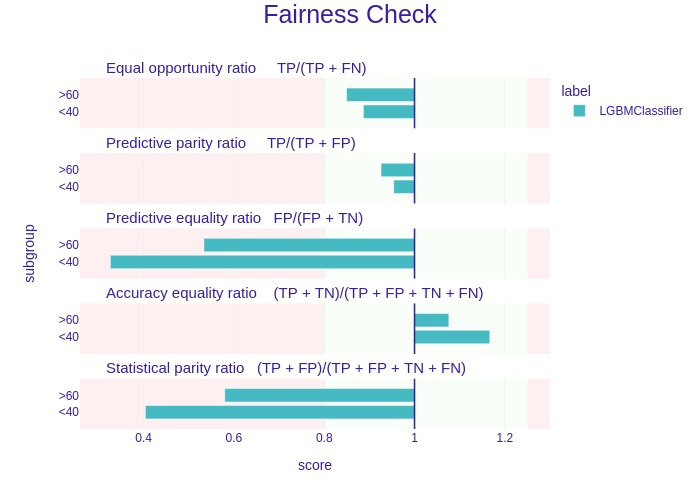

In [19]:
fairness_.plot()

The two fairness metrics that our model seems to have an issue with are:
1. Predictive equality ratio - the False Positive Rate (FPR) metric is significantly different for the 40-60 age bracket and the other two brackets. Indeed, when we look at the table above, we can see that FPV for the 40-60 age bracket is 0.343, whereas it is 0.112 for the <40 bracket and 0.183 for the >60 bracket. Intuitively, the model is overzealous in predicting the high-earner status for the 40-60 bracket compared to the other two.
2. Statistical parity ratio - the Statistical Parity (STP) metric is significantly different. In other words, the model gives a high-income prediction more readily for the 40-60 bracket (at rate of 0.552) compared to the <40 bracket (0.223) and the >60 bracket (0.320).

- Race

In [20]:
fairness_ = lgbm_expl.model_fairness(
    protected=test_X["race"],
    privileged="White",
)

fairness_.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
Amer-Indian-Eskimo,0.923,0.880,0.545,0.986,0.077,0.120,0.455,0.014,0.885,0.229
Asian-Pac-Islander,0.841,0.795,0.595,0.933,0.159,0.205,0.405,0.067,0.807,0.373
Black,0.775,0.920,0.599,0.964,0.225,0.080,0.401,0.036,0.901,0.173
Other,0.900,0.903,0.562,0.985,0.100,0.097,0.438,0.015,0.902,0.195
White,0.866,0.799,0.594,0.946,0.134,0.201,0.406,0.054,0.816,0.369


In [21]:
fairness_.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'White'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                         TPR       ACC       PPV       FPR       STP
Amer-Indian-Eskimo  1.065820  1.084559  0.917508  0.597015  0.620596
Asian-Pac-Islander  0.971132  0.988971  1.001684  1.019900  1.010840
Black               0.894919  1.104167  1.008418  0.398010  0.468835
Other               1.039261  1.105392  0.946128  0.482587  0.528455


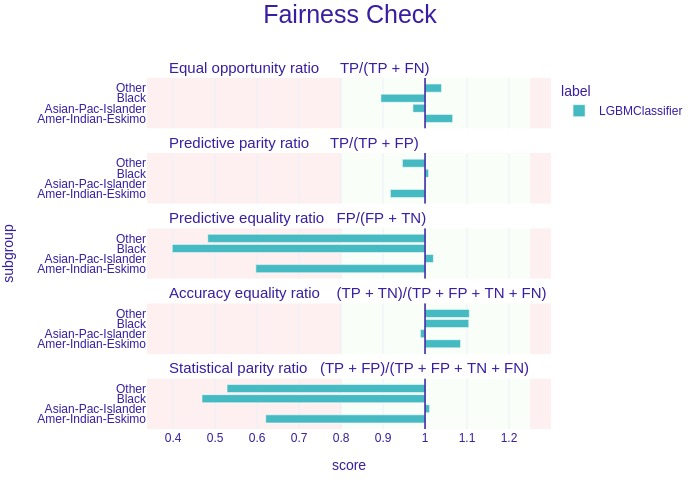

In [22]:
fairness_.plot()

It would seem that the fairness issues which affect the model in the case of the race attribute are of similar nature as for the age category, since the two violated metrics are again the predictive equality ratio and the statistical parity ratio. I would therefore like to refer the reader to the discussion regarding the results for age, and move onward to gender.

- Gender

In [23]:
fairness_ = lgbm_expl.model_fairness(
    protected=test_X["gender"],
    privileged="Male",
)

fairness_.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
Female,0.767,0.932,0.586,0.970,0.233,0.068,0.414,0.030,0.914,0.145
Male,0.878,0.739,0.595,0.933,0.122,0.261,0.405,0.067,0.782,0.448


In [24]:
fairness_.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR       ACC       PPV       FPR       STP
Female  0.873576  1.168798  0.984874  0.260536  0.323661


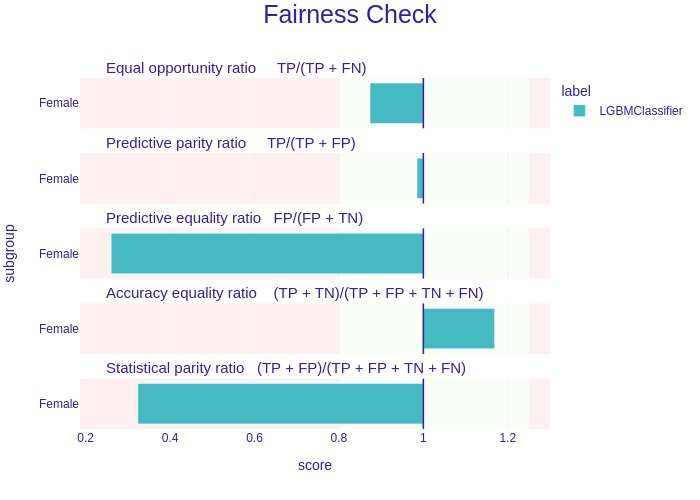

In [25]:
fairness_.plot()

And, *again*, the FPR and STP metrics prove troublesome - it's certainly very interesting that there seems to be such a persistent phenomenon at play, though I can't quite tell why is the model biased in this particular fashion.

### Task 2.3. Logistic Regression model

Now, let's do a similar thing for a Logistic Regresion model.

In [26]:
def _predict_fn(model, X_df):
    return model.predict_proba(X_conv_tf.transform(X_df))[:,1]

lr_expl = dalex.Explainer(
    lr_model,
    test_X, y_conv_tf.transform(test_y),
    predict_function=_predict_fn,
    verbose=False,
)

- Age:

In [27]:
age_protected = test_X["age"].apply(lambda age: "<40" if age < 40 else ">60" if age > 60 else "40..60")

fairness_ = lr_expl.model_fairness(
    protected=age_protected,
    privileged="40..60",
)

fairness_.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
40..60,0.861,0.667,0.602,0.892,0.139,0.333,0.398,0.108,0.739,0.527
<40,0.830,0.831,0.483,0.963,0.170,0.169,0.517,0.037,0.831,0.274
>60,0.859,0.690,0.458,0.941,0.141,0.310,0.542,0.059,0.730,0.438


In [28]:
fairness_.fairness_check()

Bias detected in 3 metrics: PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '40..60'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
          TPR       ACC       PPV       FPR       STP
<40  0.963995  1.124493  0.802326  0.507508  0.519924
>60  0.997677  0.987821  0.760797  0.930931  0.831120


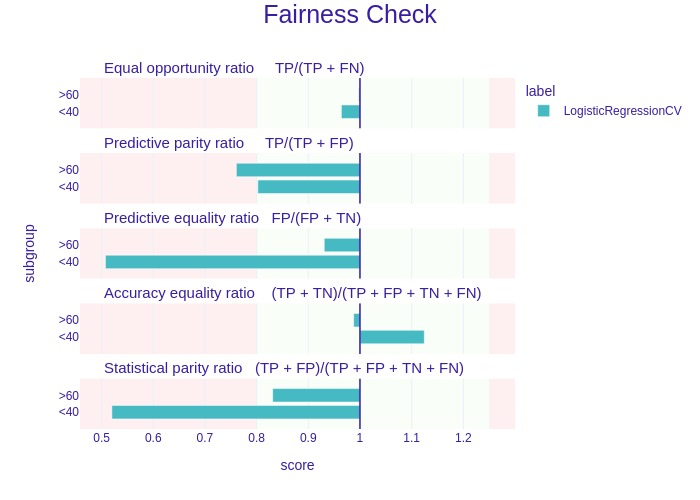

In [29]:
fairness_.plot()

Here, aside from the usual suspects, we get a new violated fairness indicator: Predictive Parity Ratio. This means that Positive Predictive Value (PPV) metric is significantly different for different subgroups - in the case of this dataset, the effect is that lower proportion of high-income predictions are correct for the disadvantaged subgroups. I would like to note that this could actually be perceived to be a positive, i.e. a case of our model overpredicting the high-income status.

- Race:

In [30]:
fairness_ = lr_expl.model_fairness(
    protected=test_X["race"],
    privileged="White",
)

fairness_.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
Amer-Indian-Eskimo,0.846,0.711,0.314,0.967,0.154,0.289,0.686,0.033,0.729,0.365
Asian-Pac-Islander,0.866,0.712,0.518,0.937,0.134,0.288,0.482,0.063,0.752,0.441
Black,0.667,0.927,0.585,0.948,0.333,0.073,0.415,0.052,0.893,0.152
Other,1.000,0.792,0.400,1.000,0.000,0.208,0.600,0.000,0.817,0.305
White,0.859,0.755,0.542,0.940,0.141,0.245,0.458,0.060,0.781,0.401


In [31]:
fairness_.fairness_check()

Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'White'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                         TPR       ACC       PPV       FPR       STP
Amer-Indian-Eskimo  0.984866  0.933419  0.579336  1.179592  0.910224
Asian-Pac-Islander  1.008149  0.962868  0.955720  1.175510  1.099751
Black               0.776484  1.143406  1.079336  0.297959  0.379052
Other               1.164144  1.046095  0.738007  0.848980  0.760599


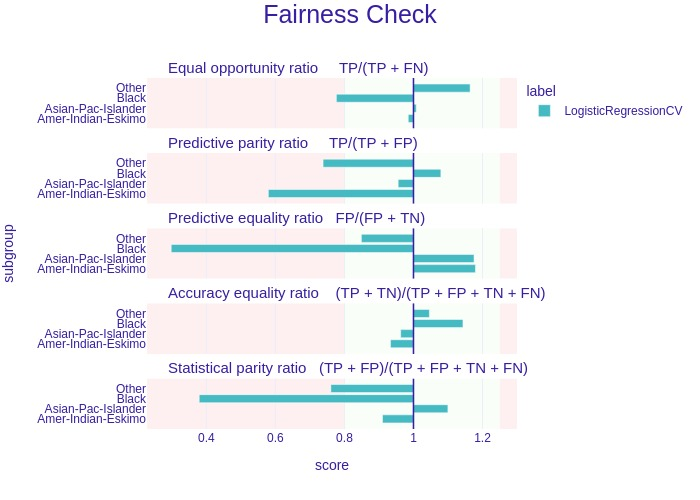

In [32]:
fairness_.plot()

For race, it would seem that logistic regression model seems to violate almost all of the fairness checks:
- Equal opportunity ratio test is violated: the model underpredicts high income status for Black high-income earners compared to White people;
- Predictive parity ratio test is violated: for American-Indian-Eskimo and Other values of the race feature, high-income predictions are less accurate;
- Regarding predictive equality ratio: the model makes less mistakes when predicting low income status for Black people compared to other groups;
- As for the statistical parity ratio: generally speaking, the model predicts low income status for Black and "Other" categories more than for White people.

- Gender:

In [33]:
fairness_ = lr_expl.model_fairness(
    protected=test_X["gender"],
    privileged="Male",
)

fairness_.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
Female,0.693,0.928,0.546,0.960,0.307,0.072,0.454,0.040,0.902,0.141
Male,0.878,0.673,0.539,0.927,0.122,0.327,0.461,0.073,0.735,0.494


In [34]:
fairness_.fairness_check()

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR       ACC       PPV       FPR       STP
Female  0.789294  1.227211  1.012987  0.220183  0.285425


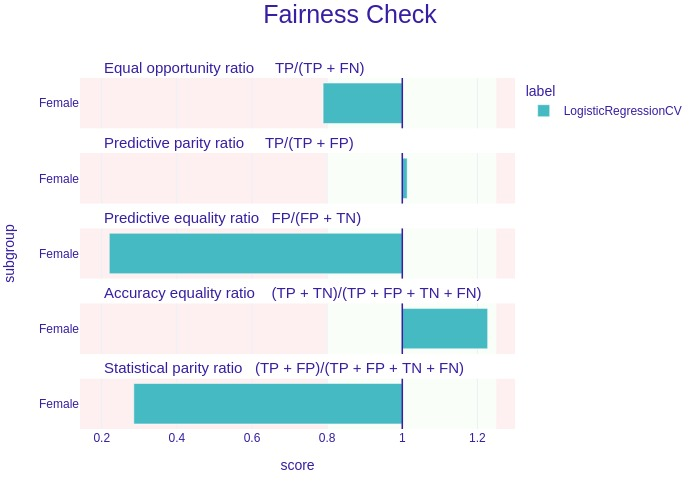

In [35]:
fairness_.plot()

(If I may, I shall skip the discussion since I would repeat myself, compared to the previous analyses.)

### Task 2.4. Apply selected bias mitigation technique

So, the models are unequivocally biased. What can we do about it? There's a number of techniques, but the first step would be to remove a given protected attribute from the set of variables. A step further would be to adjust the training procedure in such a way as to give a preferential treatment to the disprivileged subgroups, so as to "correct" the injustices present in the model. We'll perform such a procedure for the gender characteristic. As regards the "affirmative action" to be used, we will resample the dataset to create a more favorable distribution of subjects on which the model will be trained.

In [36]:
from copy import deepcopy

fair_cat_vars = [*cat_vars]
fair_cat_vars.remove("gender")

fair_tf = Pipeline(
    steps=[
        ("drop", DfColumnTransformer(
            transformers=[
                ("drop", "drop", [*vars_to_drop, "gender"]),
            ],
            remainder="passthrough",
            verbose_feature_names_out=False,
        )),
        ("fillna", DfSimpleImputer(
            missing_values="?",
            strategy="most_frequent",
            add_indicator=True,
        )),
        ("01", DfColumnTransformer(
            transformers=[
                ("01", OneHotEncoder(drop="if_binary"), [*fair_cat_vars, label_var]),
            ],
            remainder="passthrough",
            verbose_feature_names_out=False,
        )),
    ]
)

fair_df = df.drop(columns=["gender"])
fair_one_df = fair_tf.fit_transform(df)

In [37]:
fair_train_X, fair_test_X, fair_train_y, fair_test_y = \
    split(fair_df, "income")
fair_train_X_one, fair_test_X_one, fair_train_y_one, fair_test_y_one = \
    split(fair_one_df, "income_>50K")

In [38]:
fair_X_conv_tf = Pipeline(steps=[
    ("drop", DfColumnTransformer(
        transformers=[
            ("drop", "drop", [*vars_to_drop, "gender"]),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )),
    ("fillna", DfSimpleImputer(
        missing_values="?",
        strategy="most_frequent",
        add_indicator=True,
    )),
    ("01", DfColumnTransformer(
        transformers=[
            ("01", OneHotEncoder(drop="if_binary"), fair_cat_vars),
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    )),
])

fair_X_conv_tf = fair_X_conv_tf.fit(train_X)

fair_y_conv_tf = LabelEncoder()
fair_y_conv_tf = fair_y_conv_tf.fit(train_y)

In [39]:
fair_lgbm_model = OptunaTrainer().fit(fair_train_X_one, fair_train_y_one)

In [40]:
# roc_auc_score(fair_test_y_one, \
#     fair_lgbm_model.predict(fair_test_X_one))

In [41]:
pref_idxes = dalex.fairness.resample(
    train_X["gender"], train_y_one,
    type="preferential",
    probs=fair_lgbm_model.predict_proba(fair_train_X_one)[:,1],
    verbose=False,
)

pref_train_X_one = fair_train_X_one.iloc[pref_idxes]
pref_train_y_one = fair_train_y_one.iloc[pref_idxes]

In [42]:
pref_lgbm_model = OptunaTrainer().fit(pref_train_X_one, pref_train_y_one)

In [43]:
# roc_auc_score(fair_test_y_one, \
#     pref_lgbm_model.predict(fair_test_X_one))

In [44]:
def _fair_predict_fn(model, X_df):
    return model.predict_proba(fair_X_conv_tf.transform(X_df))[:,1]

lgbm_expl = dalex.Explainer(
    lgbm_model,
    test_X, y_conv_tf.transform(test_y),
    predict_function=_predict_fn,
    label="Default model",
    verbose=False,
)

fair_lgbm_expl = dalex.Explainer(
    fair_lgbm_model,
    test_X, fair_y_conv_tf.transform(test_y),
    predict_function=_fair_predict_fn,
    label="Model w/o protected attribute",
    verbose=False,
)

pref_lgbm_expl = dalex.Explainer(
    pref_lgbm_model,
    test_X, fair_y_conv_tf.transform(test_y),
    predict_function=_fair_predict_fn,
    label="Model w/ Resample mitigation",
    verbose=False,
)

In [45]:
fo_def = lgbm_expl.model_fairness(
    test_X["gender"], "Male")
fo_fair = fair_lgbm_expl.model_fairness(
    test_X["gender"], "Male")
fo_pref = pref_lgbm_expl.model_fairness(
    test_X["gender"], "Male")

In [46]:
for fo in (fo_def, fo_fair, fo_pref):
    print(f">>> {fo.label} <<<")
    fo.fairness_check()
    print()

>>> Default model <<<
Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR       ACC       PPV       FPR       STP
Female  0.873576  1.168798  0.984874  0.260536  0.323661

>>> Model w/o protected attribute <<<
Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR       ACC       PPV       FPR       STP
Female  0.899083  1.151786  0.906511  0.322835  0.361991

>>> Model w/ Resample mitigation <<<
Bias detected in 2 metrics: PPV, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon

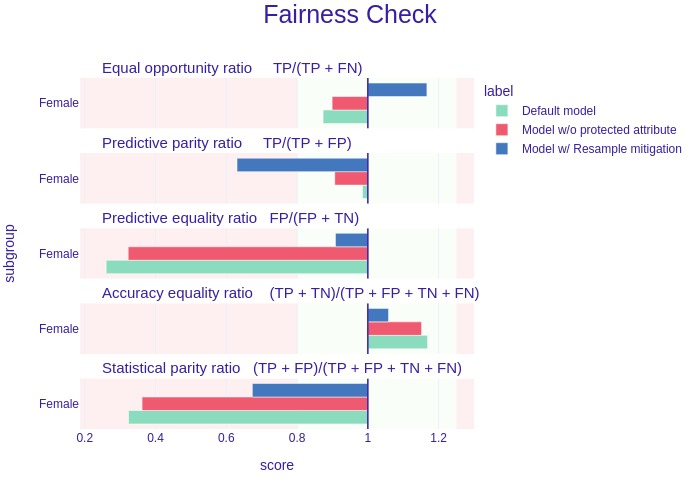

In [47]:
fo_def.plot([fo_fair, fo_pref])

In [48]:
pd.concat([
    lgbm_expl.model_performance().result, 
    fair_lgbm_expl.model_performance().result,
    pref_lgbm_expl.model_performance().result,
], axis=0)

,recall,precision,f1,accuracy,auc
Default model,0.860992,0.593805,0.702863,0.825775,0.921590
Model w/o protected attribute,0.857998,0.590695,0.699686,0.823728,0.920988
Model w/ Resample mitigation,0.750214,0.598226,0.665655,0.819634,0.892077


There are a few conclusions we can draw:
- Removing the protected attributed seems to have increased the fairness of the model a bit, though it didn't fix the issues completely. It also didn't really affect the model performance in any meaningful fashion.
- The Resample mitigation produced pronounced improvements with the Predictive parity ratio, Accuracy equality ratio and Statistical parity ratio, but unfortunately the Predictive parity ratio seems to have suffered as a result. As for the performance of the model, the drop is greater now, though arguably it's not so bad as to make the model unsuable.